In [61]:
import sys
import os
import shutil
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision.utils import make_grid
from IPython.display import Video
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.io import read_image
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image

In [62]:
if torch.cuda .is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(device)

mps


In [63]:
curr_work_dir = Path.cwd()
print(curr_work_dir)

/Users/mac/Mtcnn


In [64]:
video_dir = Path("data_video")
video_name = "pat_morgan.mp4"
video_path = video_dir / video_name
print(video_path)

data_video/pat_morgan.mp4


In [65]:
Video(video_path, embed=True)
print(video_path.exists())


True


In [66]:
video_capture = cv2.VideoCapture(str(video_path))

if not video_capture.isOpened():
    print("Error: Could not open video file.")
else:
    frame_rate = int(video_capture.get(cv2.CAP_PROP_FPS))
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Frame rate: ", frame_rate)
    print("Frame count: ", frame_count)


Frame rate:  30
Frame count:  4194


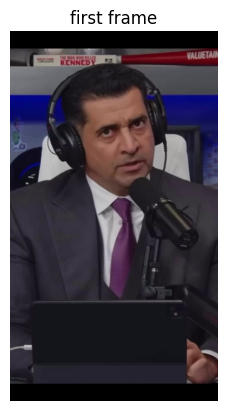

In [67]:
# Reset video pointer to first frame
video_capture.set(cv2.CAP_PROP_POS_FRAMES, 0)

success, first_frame = video_capture.read()
if success:
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title("first frame")
    plt.axis("off")
    plt.show()
else:
    print("Error: Could not read first frame.")
video_capture.release()


In [68]:
video_capture.set(cv2.CAP_PROP_POS_FRAMES, 50)

success, later_frame = video_capture.read()
if success:
    plt.imshow(cv2.cvtColor(later_frame, cv2.COLOR_BGR2RGB))
    plt.title("100th frame")
    plt.axis("off")
    plt.show()
else:
    print("Error: Could not read 10th frame.")
video_capture.release()


Error: Could not read 10th frame.


In [69]:
frames_dir = video_dir / "extracted_frames"
frames_dir.mkdir(exist_ok=True)

In [70]:
frame_count = 0

while True:
    success, frame = video_capture.read()
    if not success:
        break
    # save frames at the frame_rate
    if frame_count % 25 == 0:
        frame_path = frames_dir / f"frame_{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)
    frame_count += 1
video_capture.release()

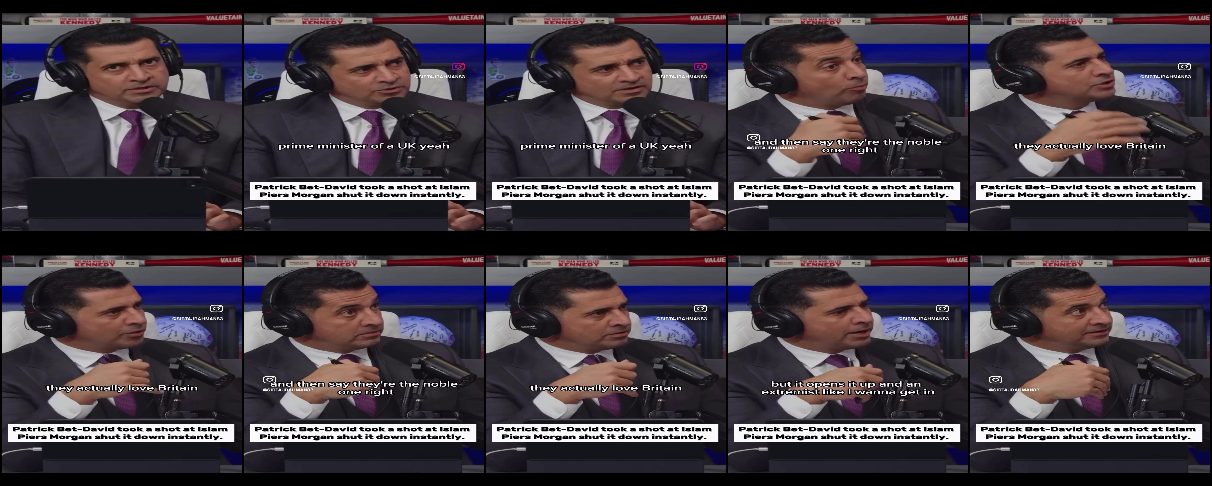

In [71]:
def display_sample_images (dir_path, sample=5) :
    image_list = []
    images = sorted(dir_path.iterdir())
    if images:
        sample_images = images [: sample]
        for sample_image in sample_images:
            image = read_image(str (sample_image))
            # Define resizing transformation that resizes to 240 x 240
            resize_transform = transforms. Resize((240, 240))
            # Resize image by using resize_transform
            image = resize_transform(image)
            image_list. append (image)
    grid = make_grid (image_list, nrow=5)
    image = to_pil_image(grid)
    return image
display_sample_images(frames_dir, sample=10)

In [72]:
MTCNN?

In [73]:
mtcnn = MTCNN(device="cpu", keep_all=True, min_face_size=60, post_process=True)
print(mtcnn)

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

In [74]:
sample_image = "frame_270.jpg"
sample_image_path = frames_dir / sample_image

sample_image =  Image.open(sample_image_path)
sample_image

In [75]:
boxes, probs = mtcnn.detect(sample_image)

print("boxes type: ", type(boxes))
print("boxes shape: ", boxes.shape)
print("probs type: ", type(probs))
print("boxes:", boxes)
print("probs:", probs)



boxes type:  <class 'numpy.ndarray'>
boxes shape:  (1, 4)
probs type:  <class 'numpy.ndarray'>
boxes: [[191.24002 267.99445 437.7778  599.9817 ]]
probs: [0.9999701]


In [76]:
number_of_faces_detected = len(boxes)
print("Number of faces detected: ", number_of_faces_detected)

Number of faces detected:  1


In [77]:
faces_with_99_prob = len(probs[probs > .99])
print("Number of faces with > 99% probability: ", faces_with_99_prob)

Number of faces with > 99% probability:  1


In [78]:
fig, ax = plt.subplots()
ax.imshow(sample_image)
for box in boxes:
    rect = plt.Rectangle(
      (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="blue"
    )
    ax.add_patch(rect)
plt.axis("off");
# plt.show()

In [79]:
boxes, probs, landmarks = mtcnn.detect(sample_image, landmarks=True)

print("boxes type: ", type(boxes))
print("probs type: ", type(probs))
print("landmarks type: ", type(landmarks))
print("boxes:", boxes)
print("probs:", probs)
print("landmarks : ", landmarks)
print("landmark  shape", landmarks.shape)

boxes type:  <class 'numpy.ndarray'>
probs type:  <class 'numpy.ndarray'>
landmarks type:  <class 'numpy.ndarray'>
boxes: [[191.24002 267.99445 437.7778  599.9817 ]]
probs: [0.9999701]
landmarks :  [[[246.69365 403.34766]
  [352.88858 407.73224]
  [281.38773 473.60553]
  [254.50258 522.94366]
  [341.55237 529.79333]]]
landmark  shape (1, 5, 2)


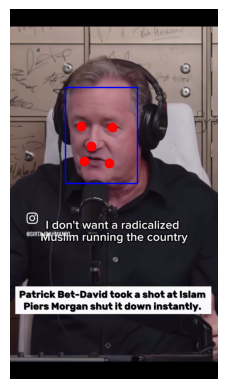

In [80]:
fig, ax = plt.subplots()
ax.imshow(sample_image)
for box, landmark in zip(boxes, landmarks):
    rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        color="blue",
    )
    ax.add_patch(rect)
    for point in landmark:
        ax.plot(point[0], point[1], marker="o", color="red")
plt.axis("off");

In [81]:
faces = mtcnn(sample_image)

print(faces.shape)

torch.Size([1, 3, 160, 160])


In [82]:
grid = torchvision.utils.make_grid(faces, nrow=4)
print(grid.shape)

torch.Size([3, 160, 160])


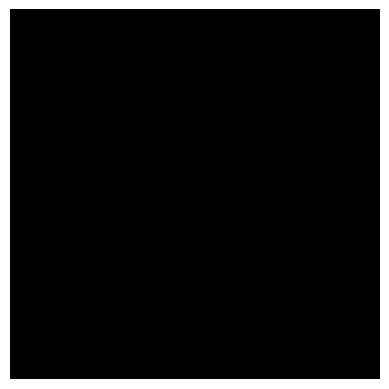

In [83]:
plt.imshow(grid.permute(1, 2, 0).int())
plt.axis('off');

In [84]:
images_dir = curr_work_dir / "data_images"
images_dir.mkdir(exist_ok=True)

In [85]:
morgan_dir = images_dir / "morgan"
morgan_dir.mkdir(exist_ok=True)

print(morgan_dir)

/Users/mac/Mtcnn/data_images/morgan


In [86]:
morgan_imgs = [
    "frame_60.jpg",
    "frame_70.jpg",
    "frame_80.jpg",
    "frame_90.jpg",
    "frame_150.jpg",
    "frame_180.jpg",
    "frame_190.jpg",
    "frame_200.jpg",
]
morgan_imgs_path = [frames_dir / img for img in morgan_imgs]

morgan_imgs_path

[PosixPath('data_video/extracted_frames/frame_60.jpg'),
 PosixPath('data_video/extracted_frames/frame_70.jpg'),
 PosixPath('data_video/extracted_frames/frame_80.jpg'),
 PosixPath('data_video/extracted_frames/frame_90.jpg'),
 PosixPath('data_video/extracted_frames/frame_150.jpg'),
 PosixPath('data_video/extracted_frames/frame_180.jpg'),
 PosixPath('data_video/extracted_frames/frame_190.jpg'),
 PosixPath('data_video/extracted_frames/frame_200.jpg')]

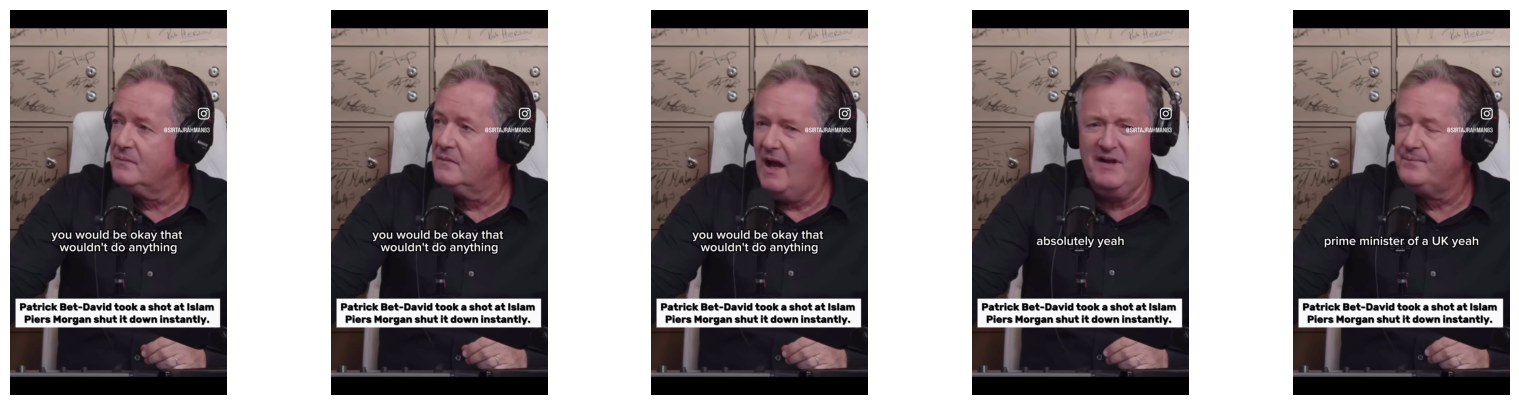

In [87]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(Image.open(morgan_imgs_path[i]))
    ax.axis("off")


In [88]:
for image_path in morgan_imgs_path:
    shutil.copy(image_path, morgan_dir)

In [89]:
patrick_dir = images_dir / "patrick"
patrick_dir.mkdir(exist_ok=True)

patrick_imgs = [
    "frame_0.jpg",
    "frame_10.jpg",
    "frame_20.jpg",
    "frame_30.jpg",
    "frame_130.jpg",
    "frame_140.jpg",
    "frame_180.jpg",
]
patrick_imgs_path = [frames_dir / img for img in patrick_imgs]

patrick_imgs_path

[PosixPath('data_video/extracted_frames/frame_0.jpg'),
 PosixPath('data_video/extracted_frames/frame_10.jpg'),
 PosixPath('data_video/extracted_frames/frame_20.jpg'),
 PosixPath('data_video/extracted_frames/frame_30.jpg'),
 PosixPath('data_video/extracted_frames/frame_130.jpg'),
 PosixPath('data_video/extracted_frames/frame_140.jpg'),
 PosixPath('data_video/extracted_frames/frame_180.jpg')]

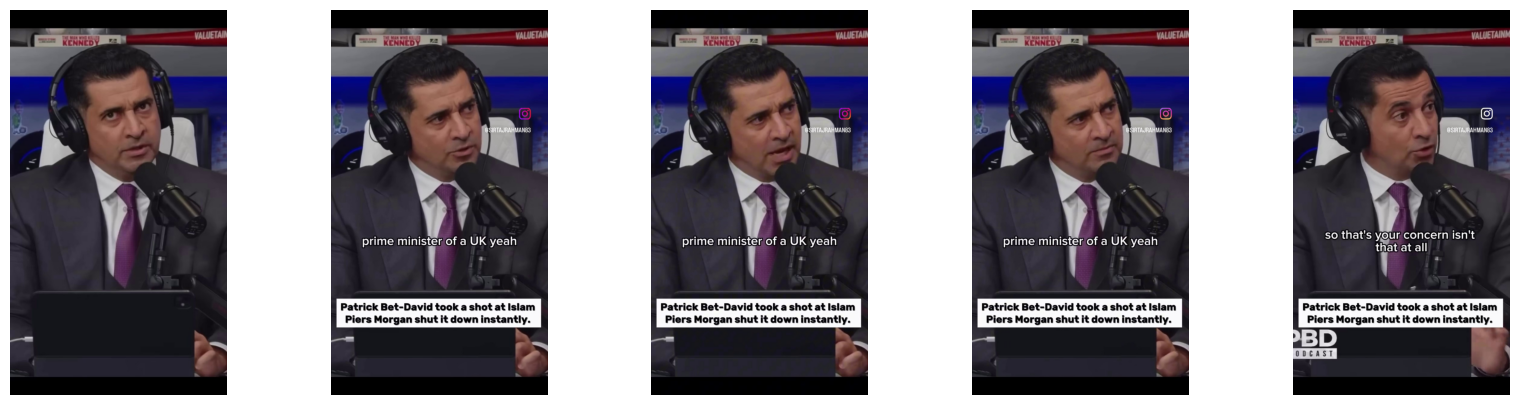

In [90]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(Image.open(patrick_imgs_path[i]))
    ax.axis("off")

for image_path in patrick_imgs_path:
  shutil.copy(image_path, patrick_dir)

In [91]:
from pathlib import Path
import torch, os, sys

print("Python:", sys.version)
cache_dir = torch.hub.get_dir()
print("Torch hub dir:", cache_dir)

cache_path = Path(cache_dir)

print("\nSearching for inception_resnet_v1 weights...")
matches = list(cache_path.rglob("inception_resnet_v1*"))
for m in matches:
    print(m, " size:", m.stat().st_size, "bytes")

if not matches:
    print("No inception_resnet_v1 files found in", cache_path)


Python: 3.11.13 (main, Jun  5 2025, 08:14:07) [Clang 14.0.6 ]
Torch hub dir: /Users/mac/.cache/torch/hub

Searching for inception_resnet_v1 weights...
No inception_resnet_v1 files found in /Users/mac/.cache/torch/hub


In [92]:
# initialize mtcnn0 that detects only one face and inception resnet for facial recognition
mtcnn0 = MTCNN(keep_all=False, device="cpu", min_face_size=40, post_process=True)
# resnet = InceptionResnetV1(pretrained="vggface2").eval()

path = "/Users/mac/.cache/torch/checkpoints/20180402-114759-vggface2.pt"
resnet = InceptionResnetV1(pretrained=None).eval()
state = torch.load(path, map_location="cpu")
state.pop("logits.weight", None)
state.pop("logits.bias", None)
resnet.load_state_dict(state, strict=False)

<All keys matched successfully>

In [93]:
images_folder = Path("data_images")
print(images_folder)

data_images


In [94]:
dataset = datasets.ImageFolder(root=images_folder)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 15
    Root location: data_images


In [95]:
for directory in images_folder.iterdir():
    print(directory)

data_images/patrick
data_images/morgan


In [96]:
dataset.class_to_idx

{'morgan': 0, 'patrick': 1}

In [97]:
idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}
idx_to_class

{0: 'morgan', 1: 'patrick'}

In [98]:
def collate_fn(x):
    return x[0]

In [99]:
loader = DataLoader(dataset, collate_fn=collate_fn)
print(loader.dataset)

Dataset ImageFolder
    Number of datapoints: 15
    Root location: data_images


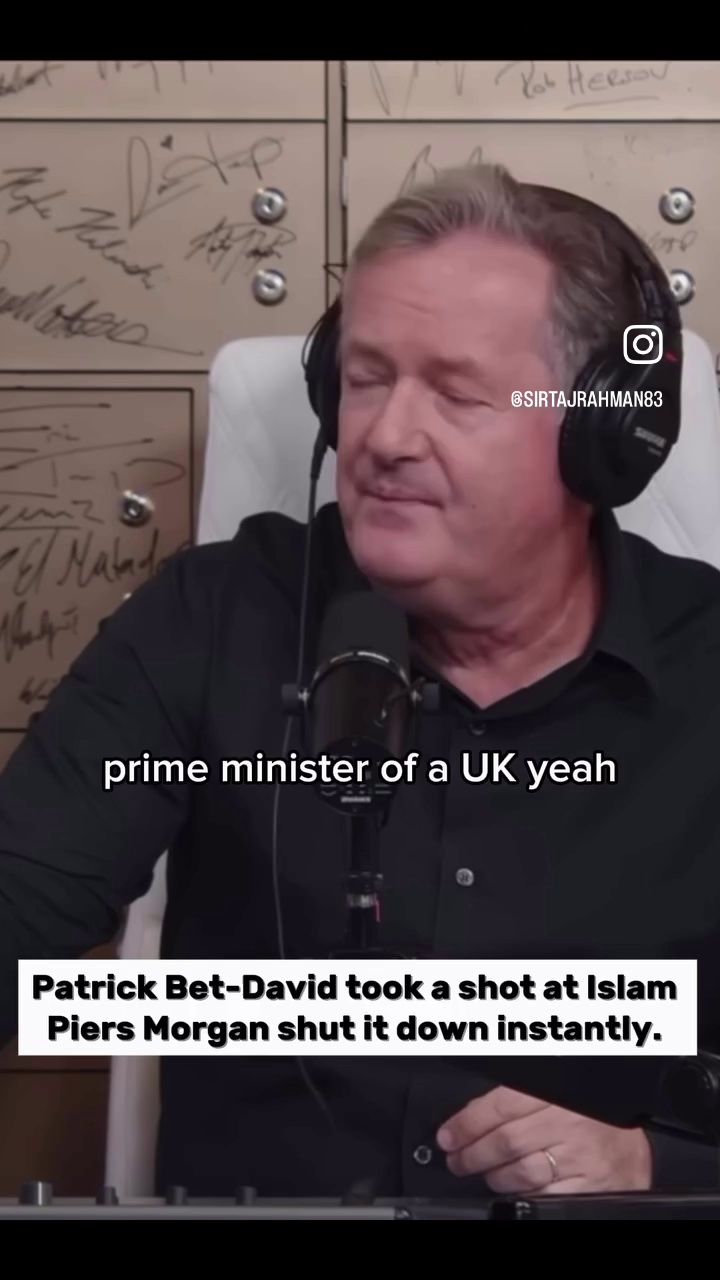

In [100]:
img, _ = iter(loader).__next__()
img

In [101]:
face, prob = mtcnn0(img, return_prob=True)
print(type(face))
print(f"Probability of detected face: {prob}")

<class 'torch.Tensor'>
Probability of detected face: 0.9999771118164062


In [102]:
try:
    resnet(face)
except ValueError as e:
    print(e)

expected 4D input (got 3D input)


In [103]:
face.shape

torch.Size([3, 160, 160])

In [104]:
face_4d = face.unsqueeze(0)
print(face_4d.shape)

torch.Size([1, 3, 160, 160])


In [105]:
embeddings = resnet(face_4d)
print(f"Embedding shape: {embeddings.shape}")

Embedding shape: torch.Size([1, 512])


In [106]:
name_to_embeddings = {name: [] for name in idx_to_class.values()}

for img, idx in loader:
    face, prob = mtcnn0(img, return_prob=True)
    if face is not None and prob >= 0.9:
        emb = resnet(face.unsqueeze(0))
        name_to_embeddings[idx_to_class[idx]].append(emb)


In [107]:
print(name_to_embeddings.keys())
print(type(name_to_embeddings["morgan"]))

dict_keys(['morgan', 'patrick'])
<class 'list'>


In [108]:
morgan_embs = torch.stack(name_to_embeddings["morgan"])
patrick_embs = torch.stack(name_to_embeddings["patrick"])
print(morgan_embs.shape)
print(patrick_embs.shape)
print(morgan_embs)
print(patrick_embs)

torch.Size([8, 1, 512])
torch.Size([7, 1, 512])
tensor([[[ 0.0170,  0.0004,  0.0549,  ..., -0.0029,  0.0069, -0.0714]],

        [[-0.0291,  0.0102, -0.0232,  ...,  0.0081, -0.0936,  0.0091]],

        [[ 0.0096, -0.0192,  0.0193,  ..., -0.0644,  0.0306, -0.0391]],

        ...,

        [[ 0.0132, -0.0235,  0.0326,  ..., -0.0210,  0.0369, -0.0536]],

        [[ 0.0052, -0.0395,  0.0086,  ..., -0.0284,  0.0190, -0.0540]],

        [[-0.0013, -0.0250,  0.0037,  ..., -0.0417,  0.0098, -0.0524]]],
       grad_fn=<StackBackward0>)
tensor([[[-0.0053, -0.0251, -0.0402,  ...,  0.0203, -0.0976, -0.0145]],

        [[-0.0322, -0.0217, -0.0340,  ...,  0.0093, -0.0877,  0.0001]],

        [[-0.0241,  0.0106, -0.0284,  ...,  0.0086, -0.0831,  0.0086]],

        ...,

        [[-0.0291,  0.0102, -0.0232,  ...,  0.0081, -0.0936,  0.0091]],

        [[-0.0123, -0.0074, -0.0203,  ...,  0.0117, -0.0922,  0.0029]],

        [[-0.0338, -0.0426, -0.0453,  ...,  0.0090, -0.0723, -0.0161]]],
       grad_fn=

In [109]:
avg_morgan_embs = torch.mean(morgan_embs, dim=0)
avg_patrick_embs = torch.mean(patrick_embs, dim=0)
print(avg_morgan_embs.shape)
print(avg_patrick_embs.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [110]:
embeddings_to_save = [(avg_morgan_embs, "morgan"), (avg_patrick_embs, "patrick")]
torch.save(embeddings_to_save, "embedded.pt")

In [111]:
embedding_data = torch.load("embedded.pt")

names = [name for _, name in embedding_data]
print(f" loaded embeddings for: {names}")

 loaded embeddings for: ['morgan', 'patrick']


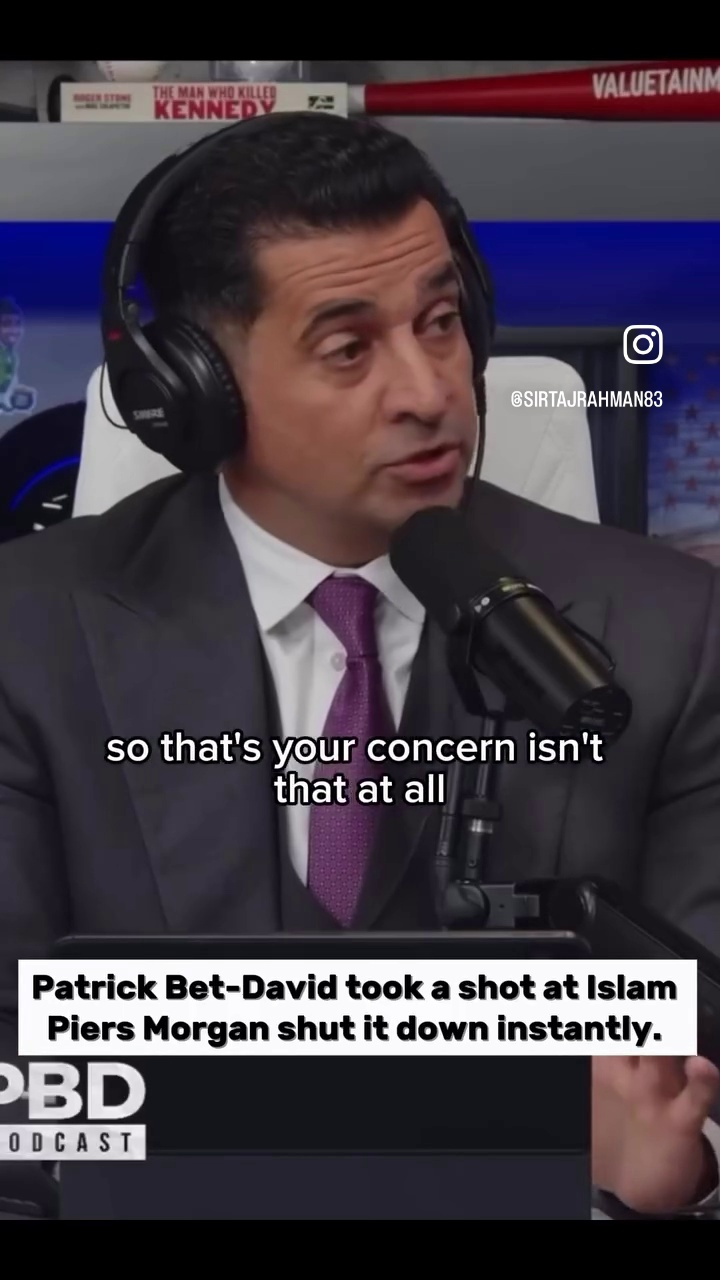

In [112]:
# our saved embeddings(faceprints) serve as database, we can take new image and check if the face of morgan or patrick is present(face recognition)

one_face_image_path = curr_work_dir / "data_video" / "extracted_frames" / "frame_140.jpg"
test_img = Image.open(one_face_image_path)
test_img

In [113]:
faces_list, prob_list = mtcnn(test_img, return_prob=True)

number_of_faces_detected = len(faces_list)
print(faces_list)
print(f"Number of faces detected: {number_of_faces_detected}")
print(F"Probability of detected face: {prob_list[0]}")

tensor([[[[-0.7852, -0.7773, -0.7695,  ..., -0.3945, -0.3945, -0.3945],
          [-0.7773, -0.7773, -0.7773,  ..., -0.3945, -0.3945, -0.3945],
          [-0.7617, -0.7617, -0.7617,  ..., -0.3945, -0.4023, -0.4023],
          ...,
          [ 0.3398,  0.3398,  0.3555,  ..., -0.6992, -0.6992, -0.6914],
          [ 0.3398,  0.3477,  0.3711,  ..., -0.7070, -0.6992, -0.6914],
          [ 0.3477,  0.3555,  0.3789,  ..., -0.7148, -0.7070, -0.6914]],

         [[-0.8008, -0.8086, -0.8086,  ..., -0.3867, -0.3867, -0.3867],
          [-0.8008, -0.8086, -0.8164,  ..., -0.3867, -0.3867, -0.3867],
          [-0.7930, -0.8086, -0.8086,  ..., -0.3867, -0.3945, -0.3945],
          ...,
          [ 0.3164,  0.3164,  0.3320,  ..., -0.7383, -0.7383, -0.7383],
          [ 0.3164,  0.3242,  0.3477,  ..., -0.7461, -0.7383, -0.7383],
          [ 0.3242,  0.3320,  0.3555,  ..., -0.7539, -0.7461, -0.7305]],

         [[-0.7773, -0.7773, -0.7773,  ..., -0.3477, -0.3477, -0.3477],
          [-0.7773, -0.7773, -

In [114]:
for i, prob in enumerate(prob_list):
    if prob > 0.9:
        emb = resnet(faces_list[i].unsqueeze(0)).detach().cpu().squeeze(0)

In [115]:
distances = {}

for known_emb, name in embedding_data:
    known_emb = known_emb
    dist = float(torch.dist(emb, known_emb))
    distances[name] = dist

closest, min_dist = min(distances.items(), key=lambda x: x[1])
print(f"Closest match: {closest}")
print(f"Calculated dist: {min_dist :.2f}")

Closest match: patrick
Calculated dist: 0.25


In [116]:
boxes, _ = mtcnn.detect(test_img)
print(boxes.shape)

(1, 4)


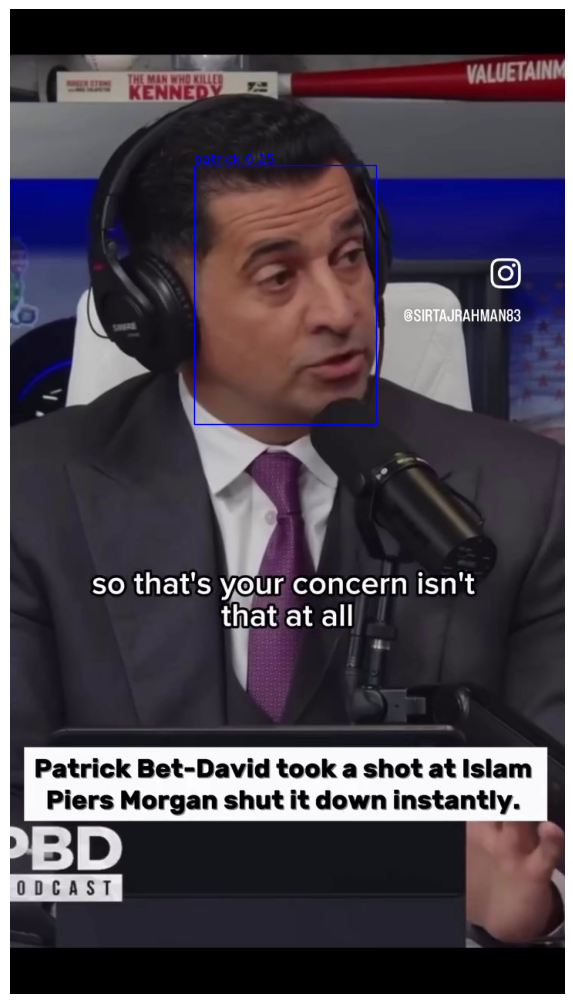

In [117]:
# let's label the boxes with the closest match to the face min distance => threshold = 1.5
width, height = test_img.size
dpi = 96
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
axis = fig.subplots()
axis.imshow(test_img)
plt.axis("off")

threshold = 0.75

for box in boxes:
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="blue"
    )
    axis.add_patch(rect)

    closest, min_dist = min(distances.items(), key=lambda x: x[1])

    # draw the b_box with the closest match name
    if min_dist < threshold:
        name = closest
        color = "blue"
    else:
        name = 'Unrecognized'
        color = "red"
    plt.text(
        box[0],
        box[1],
        f"{name} {min_dist:.2f}",
        color=color,
        ha="left",
        va="bottom",
    )
plt.axis("off")
plt.show();

In [121]:
# ResNet on image with more than one face

multi_faces_img_path = Path(curr_work_dir / "multi_faces" / "new_combined.jpg")
multi_faces_img = "manyfaces.jpg"
Image.open(multi_faces_img_path)

In [123]:
def recognize_faces(img_path, embedding_data, mtcnn, resnet, threshold=0.75):
    image = Image.open(img_path).convert("RGB")
    boxes, probs = mtcnn.detect(image)
    faces = mtcnn(image)


    if boxes is None:
        return
    width, height = image.size
    dpi = 96
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    axis = fig.subplots()
    axis.imshow(image)
    plt.axis("off")

    # iterate over each face and compare with known embedding_data
    for box, prob, face in zip(boxes, probs, faces):
        if prob < 0.9:
            continue
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False, color="green"
        )
        axis.add_patch(rect)

        # closest face to database faces
        emb = resnet(face.unsqueeze(0))
        distances = {}
        for known_emb, name in embedding_data:
            dist = float(torch.dist(emb, known_emb).item())
            distances[name] = dist
        closest, min_dist = min(distances.items(), key=lambda x: x[1])

        # label recohnized faces
        name = closest if min_dist < threshold else "Unrecognized"
        color = "red" if name == "Unrecognized" else "green"
        label = f"{name} {min_dist:.2f}"

        axis.text(box[0], box[1], label, color=color, ha="left", va="bottom", fontsize=8)

    plt.axis("off")
    plt.show();


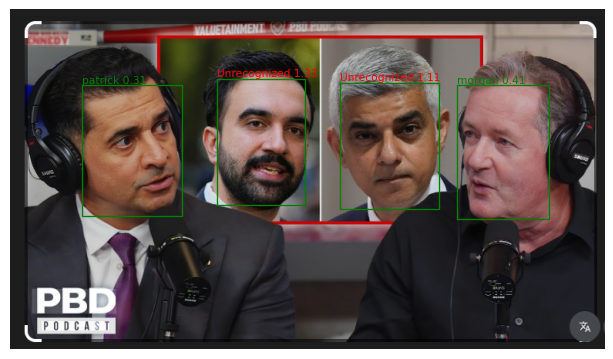

In [124]:
embedding_data = torch.load("embedded.pt")
recognize_faces(multi_faces_img_path, embedding_data, mtcnn, resnet)

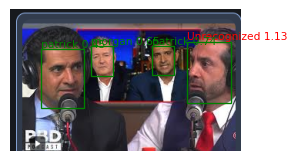

In [125]:
multi_faces_img_path = Path(curr_work_dir / "multi_faces" / "manyfaces.jpg")
recognize_faces(multi_faces_img_path, embedding_data, mtcnn, resnet)